In [1]:
import datetime
import pyaurorax

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools
at.set_theme("dark")

# Create THEMIS keogram

Keograms are a useful data product that can be generated from ASI image data. A keogram is created by stacking slices of the middle column (a N-S slice for the orientation of the UCalgary imagers) of pixels from ASI images over a period of time. 

Below, we'll work through the creation of a 1 hour keogram created from THEMIS data.

In [2]:
# download an hour of THEMIS ASI data
dataset_name = "THEMIS_ASI_RAW"
start_dt = datetime.datetime(2021, 11, 4, 9, 0)
end_dt = datetime.datetime(2021, 11, 4, 9, 59)
site_uid = "atha"
r = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)

In [3]:
# read in the hour of data
data = aurorax.data.ucalgary.read(r.dataset, r.filenames, n_parallel=5)

In [4]:
# scale all the images
#
# NOTE: you can scale all images or just one image
images_scaled = at.scale_intensity(data.data, min=1000, max=10000)

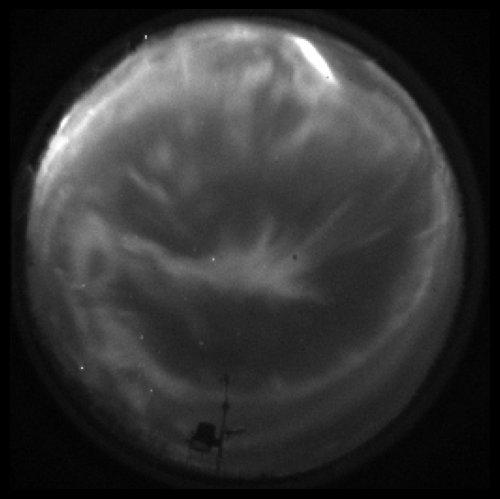

In [5]:
# show the first frame to evaluate our scaling
at.display(images_scaled[:, :, 0], cmap="gray")

## Generate keogram

Now that we have our data how we want it, let's create a basic CCD-space keogram.

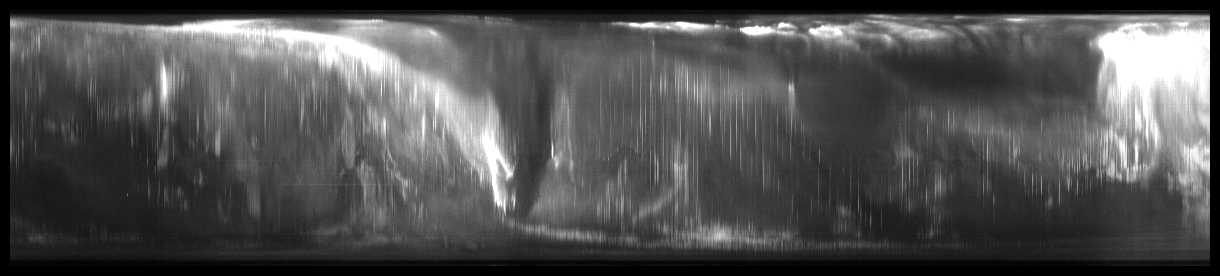

In [6]:
# create the keogram
keogram = at.keogram.create(images_scaled, data.timestamp)

# use the simple 'display' function to show it
at.display(keogram.data, cmap="gray", figsize=(12, 4))

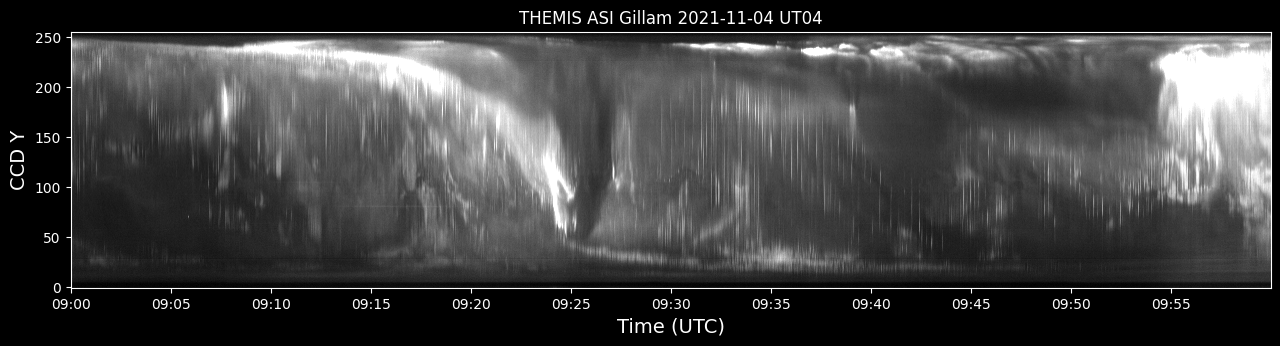

In [7]:
# use the keogram's 'plot' function instead to show the keogram
keogram.plot(
    title="THEMIS ASI Gillam %s" % (start_dt.strftime("%Y-%m-%d UT%d")),
    figsize=(12, 4),
    cmap="gray",
)

## Reference in geographic coordinates

For each camera, the UCalgary maintains a geospatial calibration dataset that maps pixel coordinates (detector X and Y) to local observer and geodetic coordinates (at altitudes of interest). We refer to this calibration as a 'skymap'. The skymaps may change due to the freeze-thaw cycle and changes in the building, or when the instrument is serviced. A skymap is valid for a range of dates. The metadata contained in a file includes the start and end dates of the period of its validity.

Be sure you choose the correct skymap for your data timeframe. The `download_best_skymap()` function is there to help you, but for maximum flexibility you can download a range of skymap files and use whichever you prefer. All skymaps can be viewed by looking at the data tree for the imager you are using (see https://data.phys.ucalgary.ca/), or using the PyAuroraX `get_urls()` or `download()` functions. If you believe the geospatial calibration may be incorrect, please contact the UCalgary team.

For more on the skymap files, please see [the skymap file description document](https://data.phys.ucalgary.ca/sort_by_project/other/documentation/skymap_file_description.pdf).

In [8]:
# download skymap file
r = aurorax.data.ucalgary.download_best_skymap("THEMIS_ASI_SKYMAP_IDLSAV", site_uid, start_dt)
skymap_data = aurorax.data.ucalgary.read(r.dataset, r.filenames).data[0]

In [9]:
# set the geographic latitudes for the keogram
keogram.set_geographic_latitudes(skymap_data)

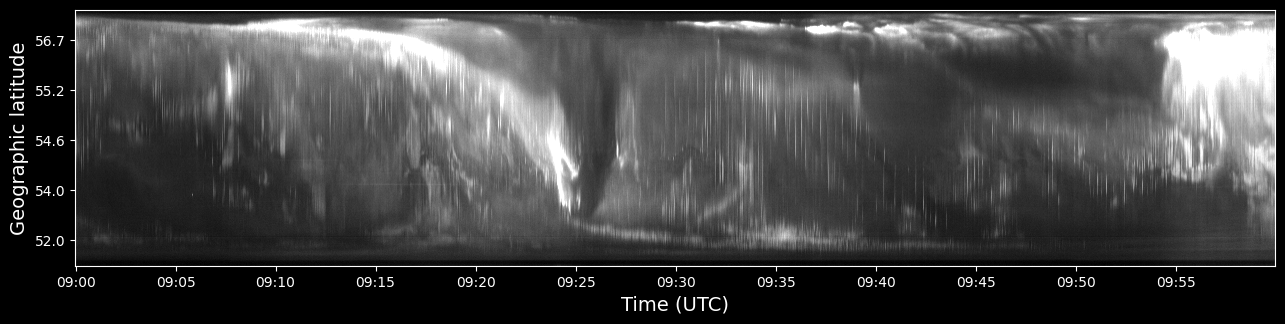

In [10]:
# plot the keogram
keogram.plot(figsize=(12, 4), cmap="gray", y_type="geo")

## Reference in magnetic coordinates

Leveraging AACGM, we can also display the keogram using magnetic latitudes.

In [11]:
# set the magnetic latitudes for the keogram
keogram.set_magnetic_latitudes(skymap_data, start_dt)

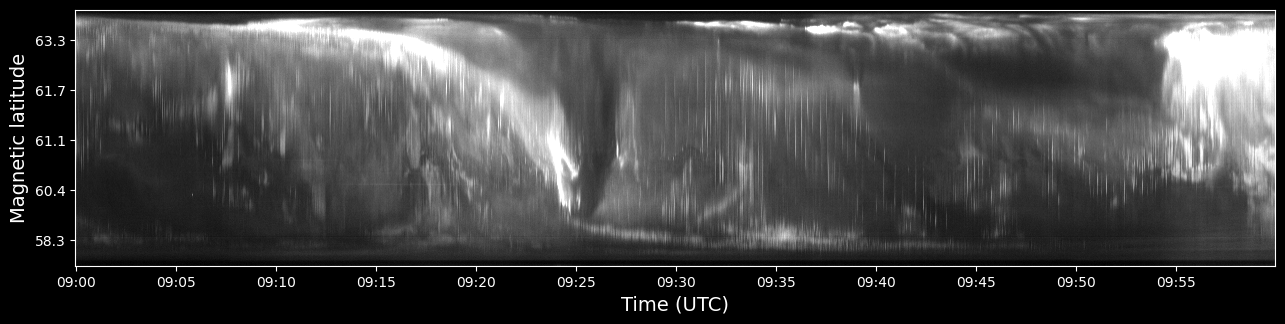

In [12]:
# plot the keogram
keogram.plot(figsize=(12, 4), cmap="gray", y_type="mag")